# How climate change perceptions vary around the world?

In [47]:
# Import libraries
import config
import pandas as pd
import numpy as np
import itertools
import collections

import tweepy
from textblob import TextBlob
from textblob import Word
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import networkx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to /home/ivana/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Interacting with twitter's API
auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret) 
auth.set_access_token(config.access_token, config.access_token_secret)
api = tweepy.API (auth, wait_on_rate_limit = True) 

In [3]:
# Clean the tweets
def clean_tweet(tweet):
    """ Utility function to clean a tweet by removing 
    links and special characters using regex.

    Parameters
    ----------
    tweet : string
        A text string that you want to parse and remove special characters.

    Returns
    -------
    The same tweet string without special characters removed.
    """
    
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())   

In [35]:
# List of tweets related to climate change
search_words = ("#ClimateChange", "Environment", "climate", "climatechange", "environmet")


def get_tweets_df(search_words):
    """Extracts tweets, finds sentiment score and returns tweets as a DataFrame 

    Parameters
    ----------
    search_words : list 
        A list of phrases to extract
    
    Returns
    -------
    Pandas DataFrame of tweets
    """
    res = []
    # Extract tweets for a given list of phrases
    for word in search_words:
        for tweet in tweepy.Cursor (api.search, 
                                    q = word + " -filter:retweets", 
                                    lang = "en").items(30):
            res.append(tweet)
   
    id_list = [tweet.id for tweet  in res]
    
    # Create tweets DataFrame
    data_set = pd.DataFrame(id_list, columns = ["id"])
    data_set["text"] = [tweet.text for tweet in res]
    data_set["len"]  = np.array([len(tweet.text) for tweet in res])
    data_set["created_at"] = [tweet.created_at for tweet in res]
    data_set["user_location"] = [tweet.author.location for tweet in res]
    data_set["Hashtags"] = [tweet.entities.get('hashtags') for tweet in res]
    
    # Use clean function to remove special characters
    data_set["text"] = np.array([ clean_tweet(tweet) for tweet in data_set['text'] ])
    
    # Add Sentiment score and class
    text = data_set["text"]
    for i in range(0,len(text)):
        textB = TextBlob(text[i])
        sentiment = textB.sentiment.polarity

        data_set.at[i, 'sentiment'] = sentiment
        if sentiment <0.00:
            SentimentClass = 'Negative'
            data_set.at[i, 'sentiment_class'] = SentimentClass 
        elif sentiment >0.00:
            SentimentClass = 'Positive'
            data_set.at[i, 'sentiment_class']= SentimentClass 
        else:
            SentimentClass = 'Neutral'
            data_set.at[i, 'sentiment_class']= SentimentClass
    
    return data_set
    

In [27]:
# Create tweets DataFrame
tweets_df = get_tweets_df(search_words)
tweets_df.head()

,id,text,len,created_at,user_location,Hashtags,sentiment,sentiment_class
0,1176795663121747969,We are currently live at the Climate Change and Occupational Health and Safety happening at Best Western Plus Atlan,140,2019-09-25 09:48:44,Ghana,[],0.378788,Positive
1,1176795613880619015,You are a man of your words Mr hyginus Your games are always Guaranteed I ll do more business with you,140,2019-09-25 09:48:32,,[],0.500000,Positive
2,1176795605504380928,Hell to the Yeah ClimateChange ActOnClimate ClimateEmergency,88,2019-09-25 09:48:30,"BRISBANE, AUSTRALIA","[{'text': 'ClimateChange', 'indices': [18, 32]}, {'text': 'ActOnClimate', 'indices': [33, 46]}, {'text': 'ClimateEmergency', 'indices': [47, 64]}]",0.000000,Neutral
3,1176795571186630656,every possible source of energy has its own Problems n Limitations n Energy is the very basis of Human Sustenan,140,2019-09-25 09:48:22,,[],0.200000,Positive
4,1176795562802237440,When videos of ClimateActivist are being shared by people who cannot live without air condition you can see the,139,2019-09-25 09:48:20,"Mumbai, India","[{'text': 'ClimateActivist', 'indices': [15, 31]}]",0.136364,Positive


### Text clean up
To preprocess the tweets we will need to replace capital letters with lower case, remove stopwords and transform words to their base form.


In [46]:
# Create a list of lists containing lowercase words for each tweet
lower_tweets = [tweet.lower().split() for tweet in tweets_df.text] 
lower_tweets[:2]

[['we',
  'are',
  'currently',
  'live',
  'at',
  'the',
  'climate',
  'change',
  'and',
  'occupational',
  'health',
  'and',
  'safety',
  'happening',
  'at',
  'best',
  'western',
  'plus',
  'atlan'],
 ['you',
  'are',
  'a',
  'man',
  'of',
  'your',
  'words',
  'mr',
  'hyginus',
  'your',
  'games',
  'are',
  'always',
  'guaranteed',
  'i',
  'll',
  'do',
  'more',
  'business',
  'with',
  'you']]

In [53]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in lower_tweets]
tweets_nsw[:2]

[['currently',
  'live',
  'climate',
  'change',
  'occupational',
  'health',
  'safety',
  'happening',
  'best',
  'western',
  'plus',
  'atlan'],
 ['man',
  'words',
  'mr',
  'hyginus',
  'games',
  'always',
  'guaranteed',
  'business']]

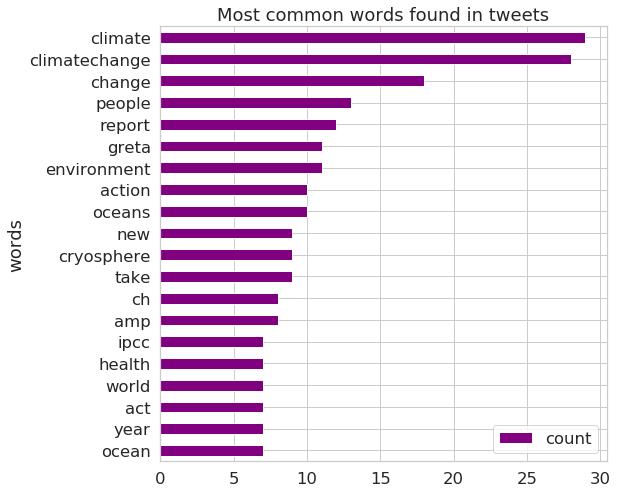

In [57]:
# Find most frequent words
all_words_nsw = list(itertools.chain(*tweets_nsw))
words_count = collections.Counter(all_words_nsw)
clean_tweets_nsw = pd.DataFrame(words_count.most_common(20), columns=['words', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common words found in tweets")
plt.show()

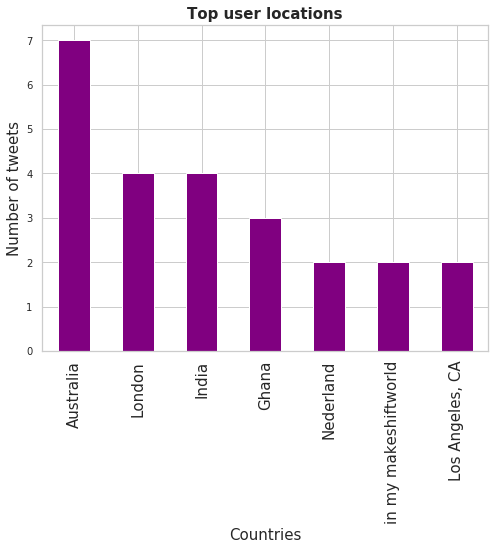

In [54]:
# Plot horizontal bar graph to see where majority of tweets are from
tweets_by_country = tweets_df['user_location'].value_counts()

fig, ax = plt.subplots(figsize=(8,6))
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top user locations',fontsize=15, fontweight='bold')
tweets_by_country[1:8].plot(ax=ax, kind='bar', color='purple')